# Ungraded Lab: Data Augmentation

In the previous lessons, you saw that having a high training accuracy does not automatically mean having a good predictive model. It can still perform poorly on new data because it has overfit to the training set. In this lab, you will see how to avoid that using _data augmentation_. This increases the amount of training data by modifying the existing training data's properties. For example, in image data, you can apply different preprocessing techniques such as rotate, flip, shear, or zoom on your existing images so you can simulate other data that the model should also learn from. This way, the model would see more variety in the images during training so it will infer better on new, previously unseen data.

Let's see how you can do this in the following sections.

## Baseline Performance

You will start with a model that's very effective at learning `Cats vs Dogs` without data augmentation. It's similar to the previous models that you have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively. The code is basically the same from the previous lab so we won't go over the details step by step since you've already seen it before.

In [1]:
# First import the necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = 'cats_and_dogs_filtered'

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print(f"Contents of base directory: {os.listdir(BASE_DIR)}")

print(f"\nContents of train directory: {os.listdir(train_dir)}")

print(f"\nContents of validation directory: {os.listdir(validation_dir)}")

Contents of base directory: ['train', 'validation']

Contents of train directory: ['dogs', 'cats']

Contents of validation directory: ['dogs', 'cats']


You will place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in this notebook.

In [3]:
def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

You will preprocess the training and validation datasets as usual.

In [4]:
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


You will train only for 20 epochs to save time but feel free to increase this if you want.

In [5]:
# Constant for epochs
EPOCHS = 5

# Create a new model
model = create_model()

# Setup the training parameters
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_dataset_final,
      epochs=EPOCHS,
      validation_data=validation_dataset_final,
      verbose=2)

Epoch 1/5
100/100 - 13s - 132ms/step - accuracy: 0.5110 - loss: 0.6940 - val_accuracy: 0.4990 - val_loss: 0.6870
Epoch 2/5
100/100 - 13s - 125ms/step - accuracy: 0.5525 - loss: 0.6852 - val_accuracy: 0.6580 - val_loss: 0.6716
Epoch 3/5
100/100 - 13s - 128ms/step - accuracy: 0.5955 - loss: 0.6659 - val_accuracy: 0.6600 - val_loss: 0.6449
Epoch 4/5
100/100 - 13s - 130ms/step - accuracy: 0.6385 - loss: 0.6376 - val_accuracy: 0.6620 - val_loss: 0.6192
Epoch 5/5
100/100 - 13s - 134ms/step - accuracy: 0.6810 - loss: 0.5993 - val_accuracy: 0.6400 - val_loss: 0.6407


You will then visualize the loss and accuracy with respect to the training and validation set. You will again use a convenience function so it can be reused later. This function accepts a [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object which contains the results of the `fit()` method you ran above.

In [6]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

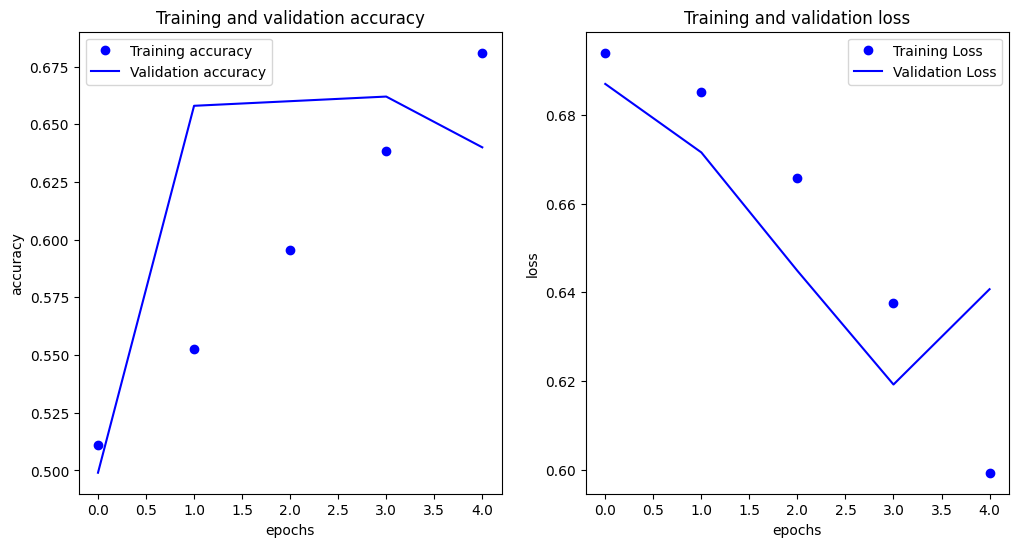

In [7]:
# Plot training results
plot_loss_acc(history)

From the results above, you'll see the training accuracy is more than 90%, and the validation accuracy is in the 70%-80% range. This is a great example of _overfitting_ -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't.


## Data augmentation

One simple method to avoid overfitting is to augment the images. If you think about it, most pictures of a cat are very similar -- the ears are at the top, the eyes are below the ears etc. Things like the distance between the eyes and ears will always be quite similar too.

What if you tweak with the images a bit -- rotate the image, squash it, etc.  That's what image augementation is all about.

To do that, you will build a data augmentation model with [preprocessing layers for image augmentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation). This will transform the data during training to introduce variations of the same image. Let's quickly go over the layers you will use in this exercise.

* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) is for randomly flipping the images horizontally, vertically, or both.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) rotates the image by an angle within a given range.
* [RandomTranslation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation) shifts pictures vertically and horizontally.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) zooms into or out of the images.

In addition, some of these layers have a `fill_mode` parameter. This is the strategy used for filling newly created pixels, which can appear after a rotation or a width/height shift.

The code below will create this model with some set parameters. After you complete this lab, feel free to modify these and see the impact on the results.

In [8]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
    # Specify the input shape.
    tf.keras.Input(shape=(150,150,3)),
    # Add the augmentation layers
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ])

You will define a utility function that lets you preview how the transformed images look like. It will take in a sample image, then output a given number of augmented images using the model you defined above.

In [9]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

Now get some images from the dataset.

In [10]:
# Get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 20


2025-04-11 07:55:48.990848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This will show sample transformations for the first 4 images of the sample batch. Notice that each call of the `data_augmentation` model yields a different output. It's like adding more images to your dataset without you having to collect them manually.

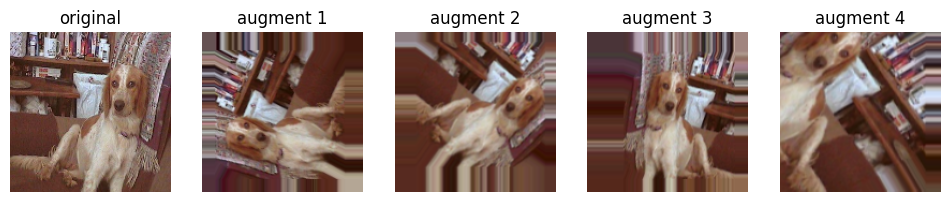

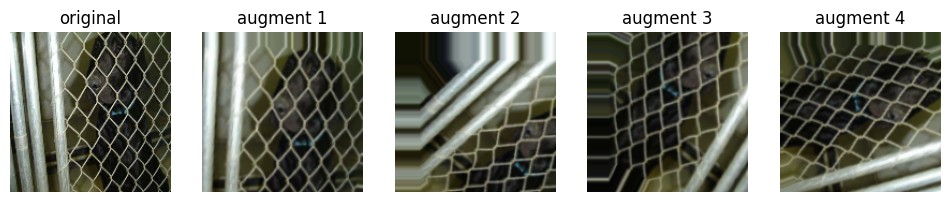

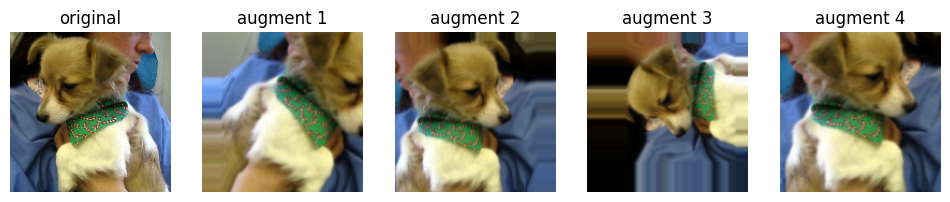

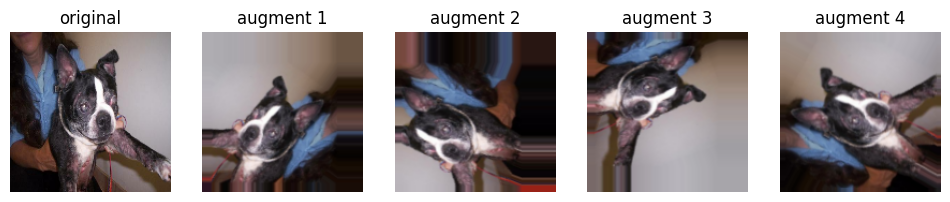

In [11]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Uncomment the line below to delete the variable to free up some memory
# del sample_batch

Now that you see what the preprocessing layers do, you can prepend these to the base model so it can generate transformed images to the base model. Do note that these layers are only active while training. They are automatically disabled during prediction and evaluation.

In [12]:
# Instantiate the base model
model_without_aug = create_model()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

# Compile the model
model_with_aug.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

Because you now have virtually more data, it will also take the model more time to learn the relevant features. Without data augmentation, your model already started overfitting to the training set within 20 epochs. Try training this model for 80 epochs and observe the results.

In [13]:
EPOCHS=10

# Train the new model
history_with_aug = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      validation_data=validation_dataset_final,
      verbose=2)

Epoch 1/10
100/100 - 14s - 140ms/step - accuracy: 0.5190 - loss: 0.6945 - val_accuracy: 0.5010 - val_loss: 0.6925
Epoch 2/10
100/100 - 14s - 138ms/step - accuracy: 0.5205 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 3/10
100/100 - 14s - 139ms/step - accuracy: 0.5345 - loss: 0.6886 - val_accuracy: 0.5320 - val_loss: 0.6799
Epoch 4/10
100/100 - 14s - 142ms/step - accuracy: 0.5660 - loss: 0.6833 - val_accuracy: 0.5810 - val_loss: 0.6667
Epoch 5/10
100/100 - 14s - 144ms/step - accuracy: 0.5810 - loss: 0.6802 - val_accuracy: 0.6260 - val_loss: 0.6585
Epoch 6/10
100/100 - 15s - 150ms/step - accuracy: 0.5825 - loss: 0.6708 - val_accuracy: 0.6120 - val_loss: 0.6571
Epoch 7/10
100/100 - 15s - 148ms/step - accuracy: 0.5885 - loss: 0.6674 - val_accuracy: 0.5910 - val_loss: 0.6700
Epoch 8/10
100/100 - 15s - 148ms/step - accuracy: 0.6020 - loss: 0.6601 - val_accuracy: 0.6380 - val_loss: 0.6335
Epoch 9/10
100/100 - 15s - 150ms/step - accuracy: 0.6245 - loss: 0.6501 - val_accuracy: 

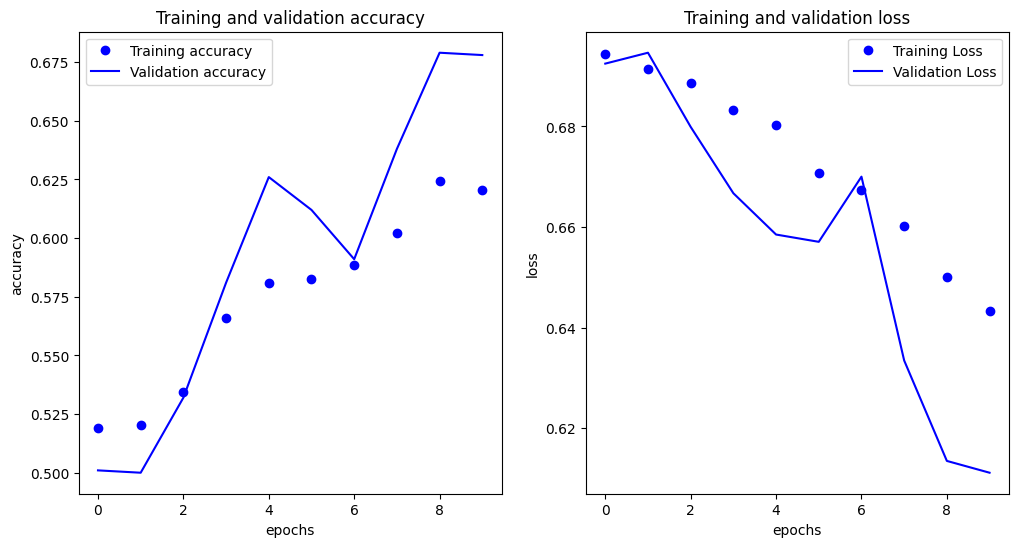

In [14]:
# Plot the results of training with data augmentation
plot_loss_acc(history_with_aug)

As you can see, the training accuracy has gone down compared to the baseline. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The good thing is the validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data.




## Wrap Up

This exercise showed a simple trick to avoid overfitting. You can improve your baseline results by simply tweaking the same images you have already. The image augmentation preprocessing layers will do just that. Try to modify the values in the augmentation model and see what results you get. You can also add other preprocessing layers for random contrast, brightness, or cropping.

Take note that this will not work for all cases. In the next lesson, Laurence will show a scenario where data augmentation will not help improve your validation accuracy.

Before going back to the classroom, run the cell below to free up resources for the next lab. You might see a pop-up about restarting the kernel afterwards. You can safely ignore it and just press Ok. You can then close this lab, then go back to the classroom for the next lecture. See you there!

In [ ]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)